# DZ Обучение сверточной сети на практике

## CNN for Cat & Doc img recognition

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import vgg16

In [2]:
import os
from random import shuffle
from glob import glob

In [3]:
# Input data - image
IMG_SIZE = (100, 100)  # let's try to difine input img size

train_files = glob('dogs-vs-cats-redux-kernels-edition/train/*.jpg')
test_files = glob('dogs-vs-cats-redux-kernels-edition/test/*.jpg')


In [4]:
# Functions

# load and preprocesing (for vgg16) input img
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  

# Generator for tran data (source local disk)
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# Generator for test data (source local disk)
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

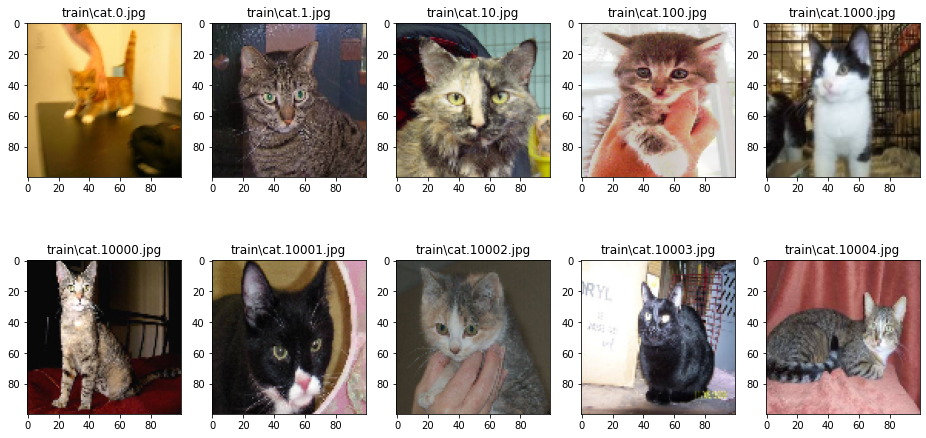

In [5]:
# Visualization of input data
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)


In [6]:
# Upload alredy trained data
# base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [7]:
# Architecture of model
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [8]:
# Modification of network by extra layers and dense layer as last layer

# weigth of pre-trained network
for layer in base_model.layers:
    layer.trainable = False

#      Adding dense layer after 5thlayer
x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1,  # due to binary classification it's only two class exsistion and whether 1 or 0
                          activation='sigmoid',  # activation function 
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

In [9]:
# Model architecture after adding layer
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)      

In [10]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # binary_crossentropy log loss function
              metrics=['accuracy'])

In [19]:
#  Crease validation part
val_samples = 300  

shuffle(train_files)
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  

model.fit(train_data,
          steps_per_epoch=50,  # number of calling in epoch
          epochs=10,  # number of epoch for training
          validation_data=validation_data)

Epoch 1/10
50/50 [==============================] - 41s 817ms/step - loss: 0.2714 - accuracy: 0.9162 - val_loss: 0.1577 - val_accuracy: 0.9400
Epoch 2/10
50/50 [==============================] - 41s 814ms/step - loss: 0.2247 - accuracy: 0.9206 - val_loss: 0.1779 - val_accuracy: 0.9367
Epoch 3/10
50/50 [==============================] - 40s 800ms/step - loss: 0.2315 - accuracy: 0.9137 - val_loss: 0.1978 - val_accuracy: 0.9233
Epoch 4/10
50/50 [==============================] - 40s 808ms/step - loss: 0.2385 - accuracy: 0.9112 - val_loss: 0.2011 - val_accuracy: 0.9300
Epoch 5/10
50/50 [==============================] - 40s 800ms/step - loss: 0.2367 - accuracy: 0.9181 - val_loss: 0.3191 - val_accuracy: 0.9333
Epoch 6/10
50/50 [==============================] - 41s 831ms/step - loss: 0.2265 - accuracy: 0.9262 - val_loss: 0.1801 - val_accuracy: 0.9333
Epoch 7/10
50/50 [==============================] - 45s 902ms/step - loss: 0.2893 - accuracy: 0.9081 - val_loss: 0.2172 - val_accuracy: 0.9233

In [20]:
# PREDICTION on test data
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

12500/12500 [==============================] - 340s 27ms/step


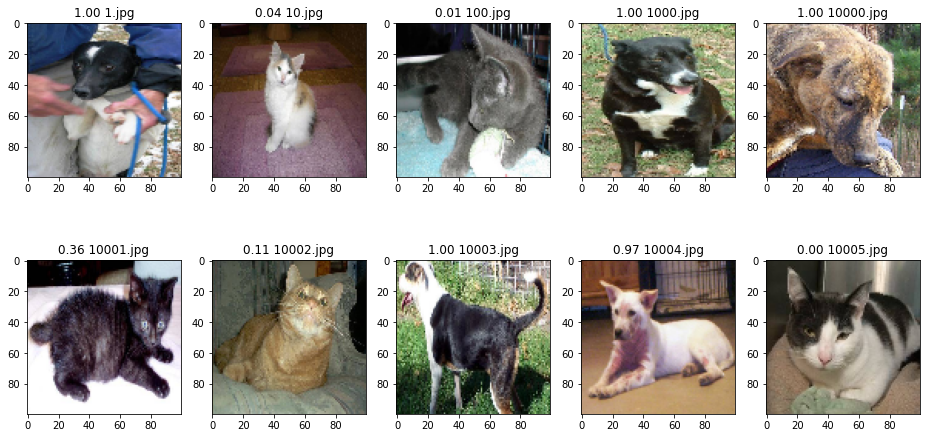

In [21]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

In [22]:
# Create file for submitting on Kaggle

import re

with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

In [ ]:
# LogLoss = 0.26551